In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import ta 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import optuna
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

dataset = pd.read_csv("Data/aapl_5m_train.csv")
dataset = dataset.drop(columns=['Volume', "Gmtoffset", "Timestamp", "Unnamed: 0", "Datetime"])
dataset.head()

,Open,High,Low,Close
0,133.570007,133.611602,132.389999,132.809997
1,132.750000,132.750000,131.809997,131.889999
2,131.500000,132.339996,131.500000,132.059997
3,132.000000,132.250000,131.899993,132.250000
4,132.000000,132.018096,131.520004,131.589996


In [5]:
def func_objective(trial, df):

    dataset = df.copy()

    lags = 7

    for lag in range (2, lags +1):
        dataset[f'lag_{lag}'] = dataset.Close.shift(lag)

    rsi_window = trial.suggest_int("rsi_window", 5, 20)
    ultimate_window1 = trial.suggest_int("ultimate_window1", 1, 10)
    ultimate_window2 = trial.suggest_int("ultimate_window2", 10, 20)
    ultimate_window3 = trial.suggest_int("ultimate_window3", 20, 30)
    williams_lbp = trial.suggest_int("williams_lbp", 10, 20)

    dataset["RSI"] = ta.momentum.RSIIndicator(dataset.Close, window=rsi_window).rsi()
    
    dataset["ultimate"] = ta.momentum.UltimateOscillator(
        high=dataset['High'], low=dataset['Low'], close=dataset['Close'],
        window1=ultimate_window1, window2=ultimate_window2, window3=ultimate_window3
    ).ultimate_oscillator()
    
    dataset['Williams'] = ta.momentum.WilliamsRIndicator(
        high=dataset['High'], low=dataset['Low'], close=dataset['Close'], lbp=williams_lbp
    ).williams_r()
    
    # Retorno futuro a 2 horas
    dataset['future_return'] = dataset['Close'].shift(-24) / dataset['Close'] - 1

    buy_threshold = 0.015
    sell_threshold = -0.015

    def generate_signal(x):
        if x > buy_threshold:
            return 'BUY'
        elif x < sell_threshold:
            return 'SELL'
        else:
            return 'WAIT'

    dataset['signal'] = dataset['future_return'].apply(generate_signal)
    
    dataset = dataset.dropna()

    X = dataset.drop("signal", axis=1)
    y = dataset[["signal"]]
    index = dataset.index

    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, index, test_size=0.2, shuffle=False
    )
    
    scaler = StandardScaler()
    
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    C = trial.suggest_float("C", 0.01, 100, log=True)
    
    svm = SVC(kernel="rbf", C=C, gamma='scale', class_weight='balanced', max_iter=10_000)
    svm.fit(X_train, y_train)
    
    ypred = svm.predict(X_test)
    
    f1_macro = f1_score(y_test, ypred, average='macro')
    
    return f1_macro
    
    

In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda t: func_objective(t, dataset), n_trials=50)

[I 2025-03-27 14:29:49,271] A new study created in memory with name: no-name-090a170d-4d0c-4697-868c-697b31f29fd7
c:\Users\AgJo413\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-03-27 14:29:50,815] Trial 0 finished with value: 0.981107238546124 and parameters: {'rsi_window': 10, 'ultimate_window1': 5, 'ultimate_window2': 10, 'ultimate_window3': 22, 'williams_lbp': 17, 'C': 21.38458894521532}. Best is trial 0 with value: 0.981107238546124.
c:\Users\AgJo413\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-03-27 14:30:08,278] Trial 1 finished with value: 0.8253464695148023 and

In [7]:
study.best_params

{'rsi_window': 11,
 'ultimate_window1': 9,
 'ultimate_window2': 18,
 'ultimate_window3': 26,
 'williams_lbp': 15,
 'C': 94.1030558440729}

In [8]:
study.best_value

0.9895527066370907

In [9]:
best_params= study.best_params
rsi_window = best_params["rsi_window"]
ultimate_window1 = best_params["ultimate_window1"]
ultimate_window2 = best_params["ultimate_window2"]
ultimate_window3 = best_params["ultimate_window3"]
williams_lbp = best_params["williams_lbp"]
C = best_params["C"]

In [10]:
dataset_opt = dataset.copy()

lags = 7 

for lag in range (2, lags +1):
    dataset_opt[f'lag_{lag}'] = dataset_opt.Close.shift(lag)

dataset_opt["RSI"] = ta.momentum.RSIIndicator(dataset_opt.Close, window=rsi_window).rsi()
    
dataset_opt["ultimate"] = ta.momentum.UltimateOscillator(
    high=dataset_opt['High'], low=dataset_opt['Low'], close=dataset_opt['Close'],
    window1=ultimate_window1, window2=ultimate_window2, window3=ultimate_window3
).ultimate_oscillator()

dataset_opt['Williams'] = ta.momentum.WilliamsRIndicator(
    high=dataset_opt['High'], low=dataset_opt['Low'], close=dataset_opt['Close'], lbp=williams_lbp
).williams_r()

# Retorno futuro a 2 horas
dataset_opt['future_return'] = dataset_opt['Close'].shift(-24) / dataset_opt['Close'] - 1

buy_threshold = 0.015
sell_threshold = -0.015

def generate_signal(x):
    if x > buy_threshold:
        return 'BUY'
    elif x < sell_threshold:
        return 'SELL'
    else:
        return 'WAIT'

dataset_opt['signal'] = dataset_opt['future_return'].apply(generate_signal)

dataset_opt = dataset_opt.dropna()

In [11]:
dataset_opt['signal'].value_counts(normalize=True)

signal
WAIT    0.876941
SELL    0.063138
BUY     0.059920
Name: proportion, dtype: float64

In [12]:
def run_backtest(dataset, initial_capital=1_000_000, n_shares=2000, com=0.125 / 100,
                 stop_loss=0.08328943650714873, take_profit=0.1052374295703637,
                 verbose=False):

    capital = initial_capital
    portfolio_value = [capital]

    wins = 0
    losses = 0

    active_long_pos = None
    active_short_pos = None

    for i, row in dataset.iterrows():
        # Cerrar posición Long activa
        if active_long_pos:
            # Cierre por stop loss
            if row.Close < active_long_pos['stop_loss']:
                pnl = row.Close * n_shares * (1 - com)
                capital += pnl
                active_long_pos = None
            # Cierre por take profit
            elif row.Close > active_long_pos['take_profit']:
                pnl = row.Close * n_shares * (1 - com)
                capital += pnl
                active_long_pos = None 
        
        # Cerrar posición Short activa
        if active_short_pos:
            if row.Close > active_short_pos['stop_loss']:
                # Recomprar caro = pérdida
                cost = row.Close * n_shares * (1 + com)
                pnl = active_short_pos['entry'] * n_shares - cost
                capital -= pnl  # Restamos pérdida
                active_short_pos = None
            elif row.Close < active_short_pos['take_profit']:
                # Recomprar barato = ganancia
                pnl = active_short_pos['entry'] * n_shares - row.Close * n_shares * (1 + com)
                capital += pnl
                active_short_pos = None

        # Abrir posición Long
        if row["signal"] == 'BUY' and active_long_pos is None:
            cost = row.Close * n_shares * (1 + com)
            if capital > cost:
                capital -= cost
                active_long_pos = {
                    'datetime': row.name,
                    'opened_at': row.Close,
                    'take_profit': row.Close * (1 + take_profit),
                    'stop_loss': row.Close * (1 - stop_loss)
                }

        # Abrir posición Short (solo si no hay posición Long activa)
        if row["signal"] == 'SELL' and active_short_pos is None and active_long_pos is None:
            proceeds = row.Close * n_shares * (1 - com)
            capital += proceeds
            active_short_pos = {
                'datetime': row.name,
                'entry': row.Close,
                'take_profit': row.Close * (1 - take_profit),
                'stop_loss': row.Close * (1 + stop_loss)
            }

        # Calcular el valor de la posición actual
        position_value = 0
        if active_long_pos:
            position_value = row.Close * n_shares
        elif active_short_pos:
            position_value = active_short_pos['entry'] * n_shares - row.Close * n_shares

        # Actualizar el valor total del portafolio
        portfolio_value.append(capital + position_value)
    
    return portfolio_value, capital

In [13]:
def compute_calmar_ratio(portfolio_values, bars_per_year=20_280):
    """
    Calcula el Calmar Ratio dada la serie temporal de valores de la cartera.
    
    :param portfolio_values: lista o array con el valor de la cartera en cada barra (o día).
    :param bars_per_year: cantidad de barras en un año (252 si es diario, 4380 si son barras de 2 horas 24/7, etc.).
    :return: Calmar Ratio (float)
    """
    # Valor inicial y final
    initial_val = portfolio_values[0]
    final_val = portfolio_values[-1]
    n_bars = len(portfolio_values)

    # CAGR
    if initial_val <= 0 or final_val <= 0:
        return 0.0  # Evita divisiones por cero o valores no válidos
    
    cagr = (final_val / initial_val) ** (bars_per_year / n_bars) - 1

    # Max Drawdown
    # Para calcular MDD, podemos hacer un track del máximo acumulado y ver la caída relativa
    max_so_far = portfolio_values[0]
    max_drawdown = 0
    for pv in portfolio_values:
        if pv > max_so_far:
            max_so_far = pv
        drawdown = (max_so_far - pv) / max_so_far
        if drawdown > max_drawdown:
            max_drawdown = drawdown

    if max_drawdown == 0:
        # Si nunca hubo drawdown, el ratio sería infinito;
        # Para que no rompa, devolvemos el CAGR en lugar de infinito.
        return cagr if cagr > 0 else 0.0
    
    calmar_ratio = cagr / max_drawdown
    return calmar_ratio

In [14]:
def func_objective_backtest(trial):
    # 1) Sugerimos los hiperparámetros de la estrategia
    stop_loss = trial.suggest_float("stop_loss", 0.01, 0.2)
    take_profit = trial.suggest_float("take_profit", 0.01, 0.3)
    n_shares = trial.suggest_int("n_shares", 100, 5000, step=100)
    
    # 2) Ejecutamos el backtest con esos parámetros
    portfolio_value, final_capital = run_backtest(
        dataset_opt,  # <- dataset con señales "BUY", "SELL", "WAIT"
        initial_capital=1_000_000,
        n_shares=n_shares,
        com=0.125 / 100,  # comisiones, si las quieres fijas
        stop_loss=stop_loss,
        take_profit=take_profit,
        verbose=False
    )
    
    # 3) Calculamos el Calmar Ratio
    #    Ajusta bars_per_year según la frecuencia de tus datos
    calmar = compute_calmar_ratio(portfolio_value, bars_per_year=20_280)
    
    # 4) Retornamos el ratio que queremos maximizar
    return calmar


In [15]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(func_objective_backtest, n_trials=50)

[I 2025-03-27 14:32:24,808] A new study created in memory with name: no-name-f5d17d09-8fd4-4b8d-bddc-4e802292c202


[I 2025-03-27 14:32:26,141] Trial 0 finished with value: 8.626855148043205 and parameters: {'stop_loss': 0.10761460166777775, 'take_profit': 0.21267729902373256, 'n_shares': 1900}. Best is trial 0 with value: 8.626855148043205.
[I 2025-03-27 14:32:27,413] Trial 1 finished with value: -0.01432688414155651 and parameters: {'stop_loss': 0.16789458275444713, 'take_profit': 0.24480014031129496, 'n_shares': 3800}. Best is trial 0 with value: 8.626855148043205.
[I 2025-03-27 14:32:28,664] Trial 2 finished with value: 11.701886249533754 and parameters: {'stop_loss': 0.031033493752267778, 'take_profit': 0.2557454772867163, 'n_shares': 5000}. Best is trial 2 with value: 11.701886249533754.
[I 2025-03-27 14:32:30,199] Trial 3 finished with value: -0.025783483883189177 and parameters: {'stop_loss': 0.1690017791030737, 'take_profit': 0.2406366102140091, 'n_shares': 1100}. Best is trial 2 with value: 11.701886249533754.
[I 2025-03-27 14:32:31,530] Trial 4 finished with value: 8.219431855671502 and p

In [16]:
study2.best_params

{'stop_loss': 0.08934548942704333,
 'take_profit': 0.012816458187281457,
 'n_shares': 100}

In [17]:
study2.best_value

4962.213187489321

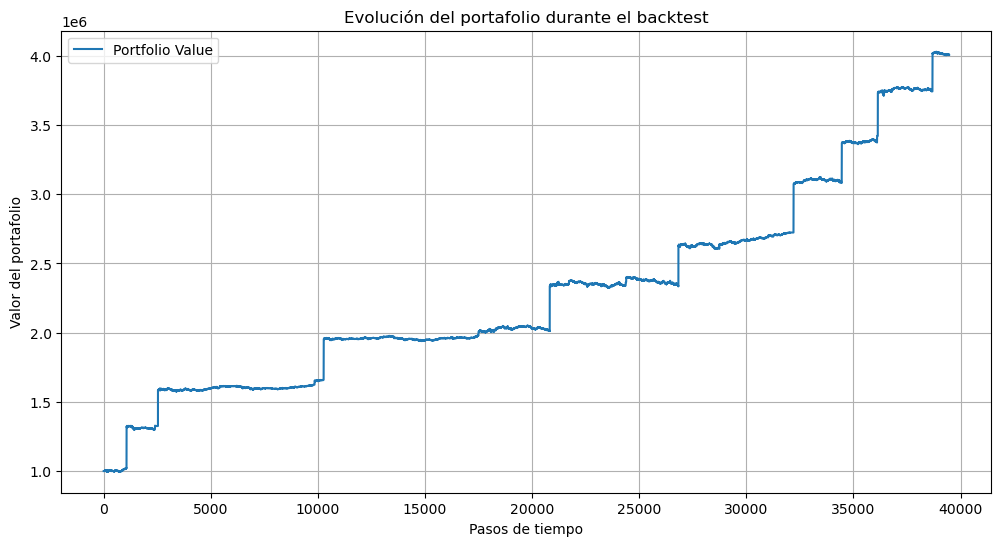

3752625.0905500012


In [21]:
portfolio_value, capital = run_backtest(dataset_opt)
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portfolio Value')
plt.title("Evolución del portafolio durante el backtest")
plt.xlabel("Pasos de tiempo")
plt.ylabel("Valor del portafolio")
plt.grid(True)
plt.legend()
plt.show()
print(capital)